In [16]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import recall_score,precision_score, f1_score, roc_auc_score, confusion_matrix ,make_scorer
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['axes.unicode_minus'] = False  # MINUS SIGN 사용 비활성화
mpl.rcParams['font.family'] = 'NanumGothic'  # 또는 다른 폰트


In [17]:
df = pd.read_csv('../파생변수데이터셋/외감_파생_ir.csv')
columns = ['이윤분배율', 'log총자산', '매출액순이익률', '비유동자산증가율', '부채비율', 
        '차입금의존도', '총자본순이익률', '자기자본구성비율', '비유동자산회전률', '매출액증가율', '부가가치율']

In [18]:
df[df['y']==1]['거래소코드'].nunique()

18546

In [19]:
# 성능확인 코드
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score, fbeta_score
import numpy as np

import warnings

def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    roc_score = roc_auc_score(y_test, pred)
    pr_score = average_precision_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    f2 = fbeta_score(y_test, pred, beta=2)
    # G-mean 계산
    tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()
    tpr = tp / (tp + fn)  # True Positive Rate
    tnr = tn / (tn + fp)  # True Negative Rate
    gmean = np.sqrt(tpr * tnr)

    print('오차행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도 : {1:.4f}, 재현율:{2:.4f},F1 스코어:{3:.4f}, f2 :{4:.4f}'.format(accuracy, precision, recall, f1, f2))
    print('ROC 스코어: {0:.4f}, PR 스코어 : {1:.4f}, G-mean : {2:.4f}'.format(roc_score, pr_score, gmean))

# 임계값에 따른 오차행렬및 스코어 -------->#임계값 최적 : 재현율기준(0.1)/f1기준(0.3)
from sklearn.preprocessing import Binarizer
thresholds = [0.1,0.15,0.2,0.25,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1)
        # ROC 커브 계산
        fpr, tpr, thresholds = roc_curve(y_test, pred_proba_c1)
        roc_auc = auc(fpr, tpr)
        print("임곗값:", custom_threshold)
        print("ROC_AUC:", roc_auc)
        get_clf_eval(y_test, custom_predict)
        print("---------------------------------------------------------")

from sklearn.metrics import roc_curve, auc
def roc(model,name) :
    # 테스트 데이터에 대한 예측 확률 계산
    pred = model.predict_proba(X_test)[:, 1]

    # ROC 커브 계산
    fpr, tpr, thresholds = roc_curve(y_test, pred)

    # AUC 계산
    roc_auc = auc(fpr, tpr)

    # ROC 커브에 AUC 면적에 색을 입히는 코드 수정
    plt.figure(figsize=(10, 6))

    # ROC 커브 시각화 및 AUC 면적 색칠
    plt.fill_between(fpr, tpr, color='palegoldenrod', alpha=0.4, label=f'Area under curve (AUC = {roc_auc:.2f})')
    plt.plot(fpr, tpr, color='peru', lw=2)

    # 기본 설정
    plt.plot([0, 1], [0, 1], color='darkorange', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{name}')
    plt.legend(loc="lower right")
    return plt.show()

In [20]:
# 클래스 레이블 y가 1인 경우에 대한 처리
for i in columns:
    # 무한대 값 제외하고 최대값, 최소값 계산
    max_value = df.loc[(df['y'] == 1) & (np.isfinite(df[i])), i].max()
    min_value = df.loc[(df['y'] == 1) & (np.isfinite(df[i])), i].min()

    # 무한대 값을 최대값 또는 최소값으로 대체
    df.loc[(df['y'] == 1) & (df[i] == np.inf), i] = max_value
    df.loc[(df['y'] == 1) & (df[i] == -np.inf), i] = min_value

# 클래스 레이블 y가 0인 경우에 대한 처리
for i in columns:
    # 무한대 값 제외하고 최대값, 최소값 계산
    max_value = df.loc[(df['y'] == 0) & (np.isfinite(df[i])), i].max()
    min_value = df.loc[(df['y'] == 0) & (np.isfinite(df[i])), i].min()

    # 무한대 값을 최대값 또는 최소값으로 대체
    df.loc[(df['y'] == 0) & (df[i] == np.inf), i] = max_value
    df.loc[(df['y'] == 0) & (df[i] == -np.inf), i] = min_value

In [21]:
train = df[df['회계년도'] <= '2020-11-01']
test = df[df['회계년도'] >= '2020-11-01']

In [22]:
len(train)

101635

In [23]:
len(train[train['y']==0]['y']), len(train[train['y']==1]['y'])

(88231, 13404)

In [24]:
len(test[test['y']==0]['y']), len(test[test['y']==1]['y'])

(45874, 6199)

In [25]:
from scipy.stats.mstats import winsorize


# 데이터프레임의 각 열에 대해 winsorize를 적용
for col in columns:
    # y == 1인 경우
    train.loc[train['y'] == 1, col] = winsorize(train.loc[train['y'] == 1, col], limits=[0.01, 0.01])
    test.loc[test['y'] == 1, col] = winsorize(test.loc[test['y'] == 1, col], limits=[0.01, 0.01])

    # y == 0인 경우
    train.loc[train['y'] == 0, col] = winsorize(train.loc[train['y'] == 0, col], limits=[0.01, 0.01])
    test.loc[test['y'] == 0, col] = winsorize(test.loc[test['y'] == 0, col], limits=[0.01, 0.01])

# 결과 확인
train[columns].describe()


,이윤분배율,log총자산,매출액순이익률,비유동자산증가율,부채비율,차입금의존도,총자본순이익률,자기자본구성비율,비유동자산회전률,매출액증가율,부가가치율
count,101635.000000,101635.000000,101635.000000,101635.000000,101635.000000,101635.000000,101635.000000,101635.000000,101635.000000,101635.000000,101635.000000
mean,2.635099,7.471867,-11.060317,16.895618,366.768568,34.693735,2.398172,44.087379,8.076822,19.910724,16.078776
std,115.336406,0.429932,179.727287,103.003094,1634.431960,30.970550,12.026207,26.898089,33.987769,150.577782,91.225844
min,-1838.270000,5.993832,-4036.770000,-96.800000,0.000000,0.000000,-118.180000,0.000000,0.000000,-91.440000,-1932.130000
25%,0.570000,7.178010,0.050000,-4.770000,41.305000,7.040000,0.070000,23.440000,0.670000,-9.140000,7.740000
50%,18.370000,7.382056,2.470000,0.320000,119.820000,31.830000,2.450000,41.400000,1.780000,1.170000,15.270000
75%,39.200000,7.683425,7.370000,12.820000,269.585000,54.050000,6.720000,64.965000,4.290000,15.050000,27.810000
max,93.250000,8.997554,119.590000,2122.420000,33825.010000,292.300000,36.380000,98.210000,650.920000,3127.300000,175.200000


In [26]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# 스케일러 초기화
scaler = StandardScaler()
scale_columns = columns

# 훈련 데이터에 대해 스케일러 학습 및 변환
train.loc[:,scale_columns] = scaler.fit_transform(train[scale_columns])

# 테스트 데이터 변환 (훈련 데이터로부터 학습된 파라미터 사용)
test.loc[:,scale_columns] = scaler.transform(test[scale_columns])

In [27]:
# X_y 분류
y_train = train['y']
X_train = train[columns]

y_test = test['y']
X_test = test[columns]

In [28]:
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN
from imblearn.under_sampling import TomekLinks, EditedNearestNeighbours

# smote = BorderlineSMOTE(k_neighbors=7, m_neighbors=7,sampling_strategy=0.25, random_state=17)
smote = ADASYN(n_neighbors=5,sampling_strategy=0.3, random_state=17)
# under = EditedNearestNeighbours(n_neighbors=5)
# SMOTE
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
# X_test, y_test = under.fit_resample(X_test,y_test)
# Checking the shape of the original and resampled data
original_shape = train.shape
resampled_shape = X_resampled.shape

original_shape, resampled_shape

((101635, 59), (112764, 11))

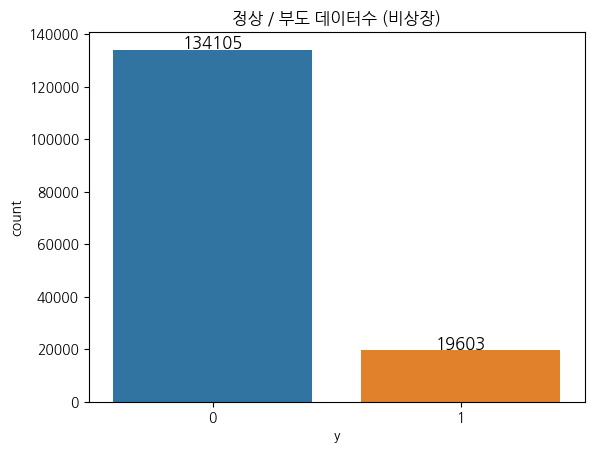

In [29]:
import seaborn as sns

ax = sns.countplot(x="y", data=df[['y']])
plt.title("정상 / 부도 데이터수 (비상장)")

# 각 막대 위에 숫자 표시
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 5),
                textcoords='offset points')


plt.show()

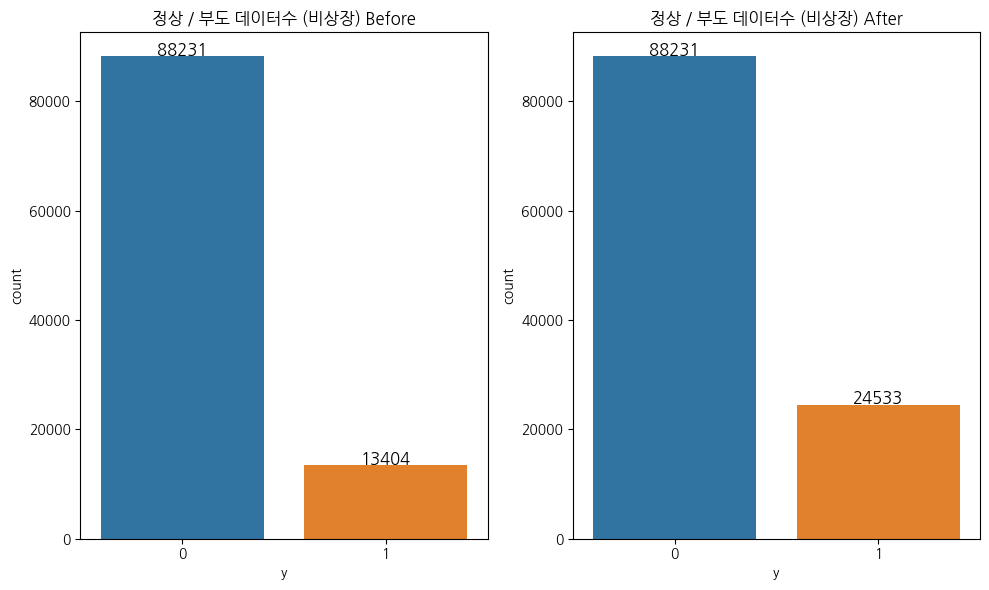

<Figure size 640x480 with 0 Axes>

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# 두 데이터셋을 시각화합니다.
plt.figure(figsize=(10, 6))
# 첫 번째 데이터셋
ax1 = plt.subplot(1, 2, 1)
sns.countplot(x="y", data=train[['y']], ax=ax1)
plt.title("정상 / 부도 데이터수 (비상장) Before")

# 각 막대 위에 숫자 표시
for p in ax1.patches:
    ax1.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 5),
                textcoords='offset points')
    
# 두 번째 데이터셋 (시리즈)
ax2 = plt.subplot(1, 2, 2)
sns.countplot(x=y_resampled, ax=ax2)
plt.title("정상 / 부도 데이터수 (비상장) After")

# 각 막대 위에 숫자 표시
for p in ax2.patches:
    ax2.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.tight_layout()
plt.show() 
plt.tight_layout()
plt.show()

In [31]:
X_train

,이윤분배율,log총자산,매출액순이익률,비유동자산증가율,부채비율,차입금의존도,총자본순이익률,자기자본구성비율,비유동자산회전률,매출액증가율,부가가치율
0,0.270383,3.548689,0.068383,-0.124420,-0.144319,-0.731787,-0.087989,-0.028901,-0.108770,-0.039121,-0.136352
1,0.029522,3.548689,0.062541,0.009460,-0.150419,-0.704664,-0.182783,0.043595,-0.129071,-0.174733,-0.144025
2,0.092902,3.548689,0.064099,-0.174128,-0.162858,-0.836726,-0.161995,0.214240,-0.149961,-0.218630,-0.138106
3,-0.022847,3.548689,-0.015689,-0.242961,-0.135674,-0.688520,-1.158157,-0.121845,-0.160259,-0.237956,-0.318429
4,0.177611,3.548689,0.066992,0.191688,-0.132394,-0.469278,-0.120419,-0.154189,-0.159082,-0.033011,-0.129885
...,...,...,...,...,...,...,...,...,...,...,...
141554,0.541071,-1.672526,0.115678,1.979702,-0.122305,-0.038222,2.825662,-0.246018,0.333450,2.636652,-0.012264
142391,-0.022847,-0.466359,0.022536,2.456194,0.611905,1.458692,-1.052554,-1.385510,-0.114066,-0.174666,-0.209906
146707,-0.022847,-1.085619,-0.367056,0.011207,-0.224402,1.933016,-1.996331,-1.639061,-0.225871,-0.593123,-0.889542
146713,-0.265877,-2.287038,-0.047459,-1.103813,-0.224402,1.205547,-1.065027,-1.639061,-0.219987,-0.126319,0.589761


In [32]:
validation = pd.DataFrame()

In [33]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
# Kfold
SPLITS = 5
kf = StratifiedKFold(n_splits = 5)
# 모델 생성
cv_logit_model = LogisticRegression(
    random_state=17
)

# Cross Validation
cv_accuracy = cross_val_score(cv_logit_model, X_resampled, y_resampled, cv=5, scoring='accuracy')
cv_precision = cross_val_score(cv_logit_model, X_resampled, y_resampled, cv=5, scoring='precision')
cv_recall = cross_val_score(cv_logit_model, X_resampled, y_resampled, cv=5, scoring='recall')
cv_f1 = cross_val_score(cv_logit_model, X_resampled, y_resampled, cv=5, scoring='f1')
cv_roc_auc = cross_val_score(cv_logit_model, X_resampled, y_resampled, cv=5, scoring='roc_auc')

print("CV_Accuracy_Scores:", cv_accuracy)
print("CV_Precision_Scores:", cv_precision)
print("CV_Recall_Scores:", cv_recall)
print("CV_F1_Scores:", cv_f1)
print("CV_ROC/AUC:", cv_roc_auc)

print('\n=======교차검증 결과=======')
print(f'CV_Accuracy_mean: {cv_accuracy.mean():.2f}')
print(f'CV_Precision_mean: {cv_precision.mean():.2f}')
print(f'CV_Recall_mean: {cv_recall.mean():.2f}')
print(f'CV_F1_스코어_mean: {cv_f1.mean():.2f}')
print(f'CV_ROC_AUC+스코어_mean: {cv_roc_auc.mean():.2f}')

# cv 결과 저장
cv_result_logit = {
    'Accuracy' : round(cv_accuracy.mean(), 2),
    'Precision': round(cv_precision.mean(), 2),
    'Recall' : round(cv_recall.mean(), 2),
    'F1' : round(cv_f1.mean(), 2),
    'ROC AUC' : round(cv_roc_auc.mean(), 2)
}
validation['LogisticRegression'] = cv_result_logit
validation

CV_Accuracy_Scores: [0.8723008  0.87988294 0.85762426 0.80100208 0.67980667]
CV_Precision_Scores: [0.97028784 0.9375     0.83281005 0.59365221 0.28935396]
CV_Recall_Scores: [0.42600897 0.47992664 0.43244345 0.27063379 0.32409295]
CV_F1_Scores: [0.59206799 0.63485645 0.56928236 0.37178052 0.30573983]
CV_ROC/AUC: [0.91166677 0.92860389 0.82756673 0.76579842 0.61156725]

=======교차검증 결과=======
CV_Accuracy_mean: 0.82
CV_Precision_mean: 0.72
CV_Recall_mean: 0.39
CV_F1_스코어_mean: 0.49
CV_ROC_AUC+스코어_mean: 0.81


,LogisticRegression
Accuracy,0.82
Precision,0.72
Recall,0.39
F1,0.49
ROC AUC,0.81


In [34]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
# Kfold
SPLITS = 5
kf = StratifiedKFold(n_splits = 5)
# 모델 생성
cv_logit_model = DecisionTreeClassifier(random_state=17, 
                            max_depth=3, 
                            )

# Cross Validation
cv_accuracy = cross_val_score(cv_logit_model, X_resampled, y_resampled, cv=5, scoring='accuracy')
cv_precision = cross_val_score(cv_logit_model, X_resampled, y_resampled, cv=5, scoring='precision')
cv_recall = cross_val_score(cv_logit_model, X_resampled, y_resampled, cv=5, scoring='recall')
cv_f1 = cross_val_score(cv_logit_model, X_resampled, y_resampled, cv=5, scoring='f1')
cv_roc_auc = cross_val_score(cv_logit_model, X_resampled, y_resampled, cv=5, scoring='roc_auc')

print("CV_Accuracy_Scores:", cv_accuracy)
print("CV_Precision_Scores:", cv_precision)
print("CV_Recall_Scores:", cv_recall)
print("CV_F1_Scores:", cv_f1)
print("CV_ROC/AUC:", cv_roc_auc)

print('\n=======교차검증 결과=======')
print(f'CV_Accuracy_mean: {cv_accuracy.mean():.2f}')
print(f'CV_Precision_mean: {cv_precision.mean():.2f}')
print(f'CV_Recall_mean: {cv_recall.mean():.2f}')
print(f'CV_F1_스코어_mean: {cv_f1.mean():.2f}')
print(f'CV_ROC_AUC+스코어_mean: {cv_roc_auc.mean():.2f}')

# cv 결과 저장
cv_result_logit = {
    'Accuracy' : round(cv_accuracy.mean(), 2),
    'Precision': round(cv_precision.mean(), 2),
    'Recall' : round(cv_recall.mean(), 2),
    'F1' : round(cv_f1.mean(), 2),
    'ROC AUC' : round(cv_roc_auc.mean(), 2)
}
validation['DT'] = cv_result_logit
validation

CV_Accuracy_Scores: [0.91779364 0.862546   0.84893362 0.79310956 0.69909542]
CV_Precision_Scores: [1.         1.         1.         1.         0.32663224]
CV_Recall_Scores: [0.62209539 0.36824944 0.30568576 0.04911351 0.36098655]
CV_F1_Scores: [0.76702689 0.53827822 0.46823786 0.09362859 0.3429512 ]
CV_ROC/AUC: [0.89628234 0.91464725 0.83667177 0.75446417 0.6453002 ]

=======교차검증 결과=======
CV_Accuracy_mean: 0.82
CV_Precision_mean: 0.87
CV_Recall_mean: 0.34
CV_F1_스코어_mean: 0.44
CV_ROC_AUC+스코어_mean: 0.81


,LogisticRegression,DT
Accuracy,0.82,0.82
Precision,0.72,0.87
Recall,0.39,0.34
F1,0.49,0.44
ROC AUC,0.81,0.81


In [35]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
# Kfold
SPLITS = 5
kf = StratifiedKFold(n_splits = 5)
# 모델 생성
cv_logit_model = RandomForestClassifier(random_state=17, 
                            )

# Cross Validation
cv_accuracy = cross_val_score(cv_logit_model, X_resampled, y_resampled, cv=5, scoring='accuracy')
cv_precision = cross_val_score(cv_logit_model, X_resampled, y_resampled, cv=5, scoring='precision')
cv_recall = cross_val_score(cv_logit_model, X_resampled, y_resampled, cv=5, scoring='recall')
cv_f1 = cross_val_score(cv_logit_model, X_resampled, y_resampled, cv=5, scoring='f1')
cv_roc_auc = cross_val_score(cv_logit_model, X_resampled, y_resampled, cv=5, scoring='roc_auc')

print("CV_Accuracy_Scores:", cv_accuracy)
print("CV_Precision_Scores:", cv_precision)
print("CV_Recall_Scores:", cv_recall)
print("CV_F1_Scores:", cv_f1)
print("CV_ROC/AUC:", cv_roc_auc)

print('\n=======교차검증 결과=======')
print(f'CV_Accuracy_mean: {cv_accuracy.mean():.2f}')
print(f'CV_Precision_mean: {cv_precision.mean():.2f}')
print(f'CV_Recall_mean: {cv_recall.mean():.2f}')
print(f'CV_F1_스코어_mean: {cv_f1.mean():.2f}')
print(f'CV_ROC_AUC+스코어_mean: {cv_roc_auc.mean():.2f}')

# cv 결과 저장
cv_result_logit = {
    'Accuracy' : round(cv_accuracy.mean(), 2),
    'Precision': round(cv_precision.mean(), 2),
    'Recall' : round(cv_recall.mean(), 2),
    'F1' : round(cv_f1.mean(), 2),
    'ROC AUC' : round(cv_roc_auc.mean(), 2)
}
validation['RF'] = cv_result_logit
validation

CV_Accuracy_Scores: [0.96514876 0.94750144 0.92413426 0.89766328 0.81664597]
CV_Precision_Scores: [0.98334115 0.97019449 0.92590618 0.82366127 0.5662485 ]
CV_Recall_Scores: [0.85426009 0.78275932 0.70796821 0.67393519 0.67162658]
CV_F1_Scores: [0.91426702 0.86645612 0.80240212 0.74131361 0.61445221]
CV_ROC/AUC: [0.991082   0.98829109 0.96158856 0.94554086 0.86751875]

=======교차검증 결과=======
CV_Accuracy_mean: 0.91
CV_Precision_mean: 0.85
CV_Recall_mean: 0.74
CV_F1_스코어_mean: 0.79
CV_ROC_AUC+스코어_mean: 0.95


,LogisticRegression,DT,RF
Accuracy,0.82,0.82,0.91
Precision,0.72,0.87,0.85
Recall,0.39,0.34,0.74
F1,0.49,0.44,0.79
ROC AUC,0.81,0.81,0.95


In [36]:
# Kfold
SPLITS = 5
kf = StratifiedKFold(n_splits = 5)
from xgboost import XGBClassifier

from lightgbm import LGBMClassifier

cv_logit_model = LGBMClassifier(random_state=17
                    )

# Cross Validation
cv_accuracy = cross_val_score(cv_logit_model, X_resampled, y_resampled, cv=5, scoring='accuracy')
cv_precision = cross_val_score(cv_logit_model, X_resampled, y_resampled, cv=5, scoring='precision')
cv_recall = cross_val_score(cv_logit_model, X_resampled, y_resampled, cv=5, scoring='recall')
cv_f1 = cross_val_score(cv_logit_model, X_resampled, y_resampled, cv=5, scoring='f1')
cv_roc_auc = cross_val_score(cv_logit_model, X_resampled, y_resampled, cv=5, scoring='roc_auc')

print("CV_Accuracy_Scores:", cv_accuracy)
print("CV_Precision_Scores:", cv_precision)
print("CV_Recall_Scores:", cv_recall)
print("CV_F1_Scores:", cv_f1)
print("CV_ROC/AUC:", cv_roc_auc)

print('\n=======교차검증 결과=======')
print(f'CV_Accuracy_mean: {cv_accuracy.mean():.2f}')
print(f'CV_Precision_mean: {cv_precision.mean():.2f}')
print(f'CV_Recall_mean: {cv_recall.mean():.2f}')
print(f'CV_F1_스코어_mean: {cv_f1.mean():.2f}')
print(f'CV_ROC_AUC+스코어_mean: {cv_roc_auc.mean():.2f}')

# cv 결과 저장
cv_result_logit = {
    'Accuracy' : round(cv_accuracy.mean(), 2),
    'Precision': round(cv_precision.mean(), 2),
    'Recall' : round(cv_recall.mean(), 2),
    'F1' : round(cv_f1.mean(), 2),
    'ROC AUC' : round(cv_roc_auc.mean(), 2)
}
validation['LGBM'] = cv_result_logit
validation

[LightGBM] [Info] Number of positive: 19627, number of negative: 70584
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021430 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 90211, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217568 -> initscore=-1.279897
[LightGBM] [Info] Start training from score -1.279897
[LightGBM] [Info] Number of positive: 19626, number of negative: 70585
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010385 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 90211, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217557 -> initscore=-1.279962
[LightGBM] [Info] Start training from score -1.279962
[LightGBM] [

,LogisticRegression,DT,RF,LGBM
Accuracy,0.82,0.82,0.91,0.88
Precision,0.72,0.87,0.85,0.79
Recall,0.39,0.34,0.74,0.61
F1,0.49,0.44,0.79,0.69
ROC AUC,0.81,0.81,0.95,0.91


In [37]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
# Kfold
SPLITS = 5
kf = StratifiedKFold(n_splits = 5)
from xgboost import XGBClassifier

cv_logit_model = XGBClassifier(random_state=17,
                    n_estimators=90,
                    max_depth=5,
                    learning_rate=0.03,
                    reg_lambda=2,
                    reg_alpha=0.02,
                    min_split_loss=2
                    )

# Cross Validation
cv_accuracy = cross_val_score(cv_logit_model, X_resampled, y_resampled, cv=5, scoring='accuracy')
cv_precision = cross_val_score(cv_logit_model, X_resampled, y_resampled, cv=5, scoring='precision')
cv_recall = cross_val_score(cv_logit_model, X_resampled, y_resampled, cv=5, scoring='recall')
cv_f1 = cross_val_score(cv_logit_model, X_resampled, y_resampled, cv=5, scoring='f1')
cv_roc_auc = cross_val_score(cv_logit_model, X_resampled, y_resampled, cv=5, scoring='roc_auc')

print("CV_Accuracy_Scores:", cv_accuracy)
print("CV_Precision_Scores:", cv_precision)
print("CV_Recall_Scores:", cv_recall)
print("CV_F1_Scores:", cv_f1)
print("CV_ROC/AUC:", cv_roc_auc)

print('\n=======교차검증 결과=======')
print(f'CV_Accuracy_mean: {cv_accuracy.mean():.2f}')
print(f'CV_Precision_mean: {cv_precision.mean():.2f}')
print(f'CV_Recall_mean: {cv_recall.mean():.2f}')
print(f'CV_F1_스코어_mean: {cv_f1.mean():.2f}')
print(f'CV_ROC_AUC+스코어_mean: {cv_roc_auc.mean():.2f}')

# cv 결과 저장
cv_result_logit = {
    'Accuracy' : round(cv_accuracy.mean(), 2),
    'Precision': round(cv_precision.mean(), 2),
    'Recall' : round(cv_recall.mean(), 2),
    'F1' : round(cv_f1.mean(), 2),
    'ROC AUC' : round(cv_roc_auc.mean(), 2)
}
validation['XGB'] = cv_result_logit
validation

CV_Accuracy_Scores: [0.93184942 0.88063672 0.86706868 0.8157673  0.75536538]
CV_Precision_Scores: [0.9952955  0.9863856  0.96904177 0.77089337 0.41920127]
CV_Recall_Scores: [0.68997146 0.45771347 0.40187487 0.21805584 0.32307379]
CV_F1_Scores: [0.81497532 0.6252784  0.56813598 0.33995234 0.36491309]
CV_ROC/AUC: [0.96887195 0.96152273 0.89237538 0.84541526 0.72281617]

=======교차검증 결과=======
CV_Accuracy_mean: 0.85
CV_Precision_mean: 0.83
CV_Recall_mean: 0.42
CV_F1_스코어_mean: 0.54
CV_ROC_AUC+스코어_mean: 0.88


,LogisticRegression,DT,RF,LGBM,XGB
Accuracy,0.82,0.82,0.91,0.88,0.85
Precision,0.72,0.87,0.85,0.79,0.83
Recall,0.39,0.34,0.74,0.61,0.42
F1,0.49,0.44,0.79,0.69,0.54
ROC AUC,0.81,0.81,0.95,0.91,0.88
